Attribution: Some of this code is from tensorflow tutorials and tensor udacity examples.

In [1]:
import cPickle as pickle
import numpy as np
import tensorflow as tf
import tarfile
import ntpath
import cPickle, gzip
import os
from six.moves import urllib
import sys
import time
import math

In [2]:
data_dir = "."
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

def maybe_download():
    """Download and extract the tarball from Alex's website."""
    dest_directory = data_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, reporthook=_progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')

def load_cifar_10_dataset():
    print "Opening CIFAR 10 dataset"
    dataset = {}
    with tarfile.open(data_dir + "/cifar-10-python.tar.gz", "r:gz") as tar:
        for member in tar.getmembers():
            if member.isfile():
                if "_batch" in member.name:
                    file_name = ntpath.basename(member.name)
                    f = tar.extractfile(member)
                    batch_dataset = cPickle.load(f) 
                    dataset[file_name] = batch_dataset
                elif member.name.endswith("batches.meta"):
                    f = tar.extractfile(member)
                    label_names = cPickle.load(f) 
                    dataset["meta"] = label_names
    print "Finished opening CIFAR 10 dataset"
    return dataset

def merge_datasets(dataset_one, dataset_two):
    return {
        "data": np.concatenate((dataset_one["data"], dataset_two["data"])),
        "labels": dataset_one["labels"] + dataset_two["labels"], 
    }

def get_merged_training_datasets(dataset_batches_dict):
    training_dataset_names = [ "data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4" ]
    training_datasets = map(lambda name: dataset_batches_dict[name], training_dataset_names)
    training_dataset_and_labels = reduce(merge_datasets, training_datasets)
    validation_dataset_and_labels = dataset_batches_dict["data_batch_5"]
    test_dataset_and_labels = dataset_batches_dict["test_batch"]
    return (
        np.asarray(training_dataset_and_labels["data"]), np.asarray(training_dataset_and_labels["labels"]),
        np.asarray(validation_dataset_and_labels["data"]), np.asarray(validation_dataset_and_labels["labels"]),
        np.asarray(test_dataset_and_labels["data"]), np.asarray(test_dataset_and_labels["labels"])
    )

maybe_download()
dataset_batches_dict = load_cifar_10_dataset()
label_names = dataset_batches_dict["meta"]["label_names"]
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = get_merged_training_datasets(dataset_batches_dict)

print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

()
('Successfully downloaded', 'cifar-10-python.tar.gz', 170498071, 'bytes.')
Opening CIFAR 10 dataset
Finished opening CIFAR 10 dataset
Training set (40000, 3072) (40000,)
Validation set (10000, 3072) (10000,)
Test set (10000, 3072) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 32
num_labels = 10
num_channels = 3 # RGB


def reformat(dataset, labels):
    #dataset = dataset.reshape(
    #  (-1, image_size, image_size, num_channels)).astype(np.float32)
    
    # the dataset is of a shape (*, num_channels * image_size * image_size) 
    # with the red values first, followed by the green, then blue.
    dataset = dataset
    x = dataset.reshape((-1, num_channels, image_size * image_size)) # break the channels into their own axes.
    y = x.transpose([0, 2, 1]) # This transpose the matrix by swapping the second and third axes, but not the first. This puts matching RGB values together
    reformated_dataset = y.reshape((-1, image_size, image_size, num_channels)).astype(np.float32) # Turn the dataset into a 4D tensor of a collection of images, with axes of width, height and colour channels.
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return reformated_dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (40000, 32, 32, 3) (40000, 10)
Validation set (10000, 32, 32, 3) (10000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [4]:
def get_best_step(steps_to_predictions, labels):
    best_accuracy = 0
    best_accuracy_step = 0
    for step, predictions in steps_to_predictions.iteritems():
        acc = accuracy(predictions, labels)
        steps_to_predictions[step] = predictions
        if acc > best_accuracy:
            best_accuracy = acc
            best_accuracy_step = step
    return best_accuracy, best_accuracy_step

def visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions):
    best_validation_accuracy, best_validation_step = get_best_step(steps_to_validation_predictions, valid_labels)
    print "The best validation accuracy was %s at step %s" % (best_validation_accuracy, best_validation_step)
    best_test_accuracy, best_test_step = get_best_step(steps_to_test_predictions, test_labels)
    print "The best test accuracy was %s at step %s" % (best_test_accuracy, best_test_step)
    
    best_prediction = steps_to_test_predictions[best_test_step]
    correct_prediction_indexes = []
    incorrect_prediction_indexes = []
    index = 0
    for accurate in np.argmax(best_prediction, 1) == np.argmax(test_labels, 1):
        if accurate:
            correct_prediction_indexes.append(index)
        else:
            incorrect_prediction_indexes.append(index)
        index += 1
    return correct_prediction_indexes, incorrect_prediction_indexes

%matplotlib inline

import matplotlib.pyplot as plt
from random import randint, shuffle

def get_index_of_one_hot_vector(one_hot_vector):
    for i in range(len(one_hot_vector)):
        if one_hot_vector[i] == 1.0:
            return i
    raise "Not a one_hot_vector"
    
def display_test_data(data_set, labels, data_index, figure, subplot_index, width=5, height=5):
    a = figure.add_subplot(width, height, subplot_index)
    data = data_set[data_index,:,:,:]
    decimal_code_to_fraction_quotient = 255.0
    reshaped_data = data.reshape((image_size, image_size,-1)).astype(np.float32) / decimal_code_to_fraction_quotient
    plt.axis("off")
    #plt.figure(figsize=(100, 100))
    plt.imshow(reshaped_data, cmap=plt.cm.hot)
    label = get_index_of_one_hot_vector(labels[data_index])
    a.set_title(label_names[label])
    
def display_random_data(data_set, labels, number_of_data=25):
    figure_size = math.ceil(pow(number_of_data, 0.5))
    figure = plt.figure()
    for i in range(number_of_data):
        data_index = randint(0, len(data_set) - 1)
        display_test_data(data_set, labels, data_index, figure, i, width=figure_size, height=figure_size)

    figure.subplots_adjust(hspace=1.5)

def display_data(dataset, labels, indexes, number_of_data=25):
    figure_size = math.ceil(pow(number_of_data, 0.5))
    figure = plt.figure()
    for i in range(number_of_data):
        display_test_data(dataset, labels, indexes[i], figure, i, width=figure_size, height=figure_size)

    figure.subplots_adjust(hspace=1.5)

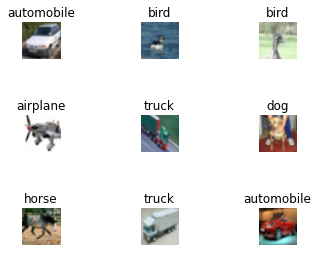

In [5]:
display_size = 9
index_start = 45
display_data(train_dataset, train_labels, range(index_start, index_start + display_size), number_of_data=display_size)

In [5]:
import time
import math

class Model():
    
    def __init__(self, graph, batch_size, tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset, dropout_keep_probability, logits, loss, optimizer, train_prediction, valid_prediction, test_prediction):
        self.graph = graph
        self.batch_size = batch_size
        self.tf_train_dataset = tf_train_dataset
        self.tf_train_labels = tf_train_labels
        self.tf_valid_dataset = tf_valid_dataset
        self.tf_test_dataset = tf_test_dataset
        self.dropout_keep_probability = dropout_keep_probability
        self.logits = logits
        self.loss = loss
        self.optimizer = optimizer
        self.train_prediction = train_prediction
        self.valid_prediction = valid_prediction
        self.test_prediction = test_prediction
        
def get_l2_loss(l2_lambda, layer_weights):
    return l2_lambda * sum(map(tf.nn.l2_loss, layer_weights))

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def create_same_padding_3_conv_one_hidden_model(learning_rate = 0.05, initialised_weights_stddev = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, batch_size = 32, l2_lambda = 0.1, decay_steps = 10000, decay_rate = 0.96):
    patch_size = 5
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        dropout_keep_probability = tf.placeholder(tf.float32)
        
        # Variables
        layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        layer1_biases = tf.Variable(tf.zeros([feature_maps]))

        layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        layer2_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))


        conv_layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))

        #layel3_weights = tf.Variable(tf.truncated_normal(
        #    [image_size / 4 * image_size / 4 * feature_maps, number_of_hidden_neurons], stddev=initialised_weights_stddev))
        number_of_conv_layers = 3
        layer3_weights = tf.Variable(tf.truncated_normal(
            [int(math.ceil(image_size / (2.0 ** number_of_conv_layers)) * math.ceil(image_size / (2.0 ** number_of_conv_layers)) * feature_maps), number_of_hidden_neurons], stddev=initialised_weights_stddev))
        layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[number_of_hidden_neurons]))


        layer4_weights = tf.Variable(tf.truncated_normal(
            [number_of_hidden_neurons, num_labels], stddev=initialised_weights_stddev))
        layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[num_labels]))
        
        

        # Model.
        def create_model_graph(data, add_dropout = False):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer1_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer2_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

            conv = tf.nn.conv2d(hidden, conv_layer3_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer3_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            if add_dropout:
                hidden = tf.nn.dropout(hidden, dropout_keep_probability)
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = create_model_graph(tf_train_dataset, add_dropout = True)
        layer_weights = [layer1_weights, layer2_weights, conv_layer3_weights, layer3_weights, layer4_weights]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + get_l2_loss(l2_lambda, layer_weights))

        # Optimizer.
        global_step = tf.Variable(0, name="global_step", trainable=False)
        decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(decayed_learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(create_model_graph(tf_valid_dataset))
        test_prediction = tf.nn.softmax(create_model_graph(tf_test_dataset))
        
        return Model(graph, batch_size, tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset, dropout_keep_probability, logits, loss, optimizer, train_prediction, valid_prediction, test_prediction)

def create_cv_cv_mp_cv_cv_mp_one_hidden_model(learning_rate = 0.05, initialised_weights_stddev = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, batch_size = 32, l2_lambda = 0.1, decay_steps = 10000, decay_rate = 0.96):
    patch_size = 5
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        dropout_keep_probability = tf.placeholder(tf.float32)
        
        # Variables
        layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        layer1_biases = tf.Variable(tf.zeros([feature_maps]))

        layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        layer2_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))


        conv_layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer4_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))

        number_of_max_pool_layers = 2
        conv_output_size = int(math.ceil(image_size / (2.0 ** number_of_max_pool_layers)) * math.ceil(image_size / (2.0 ** number_of_max_pool_layers)) * feature_maps)
        #print "conv_output_size %s" % conv_output_size
        layer3_weights = tf.Variable(tf.truncated_normal(
            [conv_output_size, number_of_hidden_neurons], stddev=initialised_weights_stddev))
        layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[number_of_hidden_neurons]))


        layer4_weights = tf.Variable(tf.truncated_normal(
            [number_of_hidden_neurons, num_labels], stddev=initialised_weights_stddev))
        layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[num_labels]))

        # Model.
        def create_model_graph(data, add_dropout = False):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer1_biases)
            shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer2_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            conv = tf.nn.conv2d(hidden, conv_layer3_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + conv_layer3_biases)
            
            conv = tf.nn.conv2d(hidden, conv_layer4_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer4_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            if add_dropout:
                hidden = tf.nn.dropout(hidden, dropout_keep_probability)
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = create_model_graph(tf_train_dataset, add_dropout = True)
        layer_weights = [layer1_weights, layer2_weights, conv_layer3_weights, conv_layer4_weights, layer3_weights, layer4_weights]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + get_l2_loss(l2_lambda, layer_weights))

        # Optimizer.
        global_step = tf.Variable(0, name="global_step", trainable=False)
        decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(decayed_learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(create_model_graph(tf_valid_dataset))
        test_prediction = tf.nn.softmax(create_model_graph(tf_test_dataset))
        
        return Model(graph, batch_size, tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset, dropout_keep_probability, logits, loss, optimizer, train_prediction, valid_prediction, test_prediction)
    

def create_three_double_conv_layers_one_hidden_model(learning_rate = 0.05, initialised_weights_stddev = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, batch_size = 32, l2_lambda = 0.1, decay_steps = 10000, decay_rate = 0.96):
    patch_size = 5
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        dropout_keep_probability = tf.placeholder(tf.float32)
        
        # Variables
        layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        layer1_biases = tf.Variable(tf.zeros([feature_maps]))

        layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        layer2_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))

        conv_layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer4_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer5_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer5_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer6_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer6_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))

        number_of_max_pool_layers = 3
        conv_output_size = int(math.ceil(image_size / (2.0 ** number_of_max_pool_layers)) * math.ceil(image_size / (2.0 ** number_of_max_pool_layers)) * feature_maps)
        #print "conv_output_size %s" % conv_output_size
        layer3_weights = tf.Variable(tf.truncated_normal(
            [conv_output_size, number_of_hidden_neurons], stddev=initialised_weights_stddev))
        layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[number_of_hidden_neurons]))


        layer4_weights = tf.Variable(tf.truncated_normal(
            [number_of_hidden_neurons, num_labels], stddev=initialised_weights_stddev))
        layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[num_labels]))

        # Model.
        def create_model_graph(data, add_dropout = False):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer1_biases)
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer2_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            conv = tf.nn.conv2d(hidden, conv_layer3_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + conv_layer3_biases)
            
            conv = tf.nn.conv2d(hidden, conv_layer4_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer4_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape
            
            conv = tf.nn.conv2d(hidden, conv_layer5_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + conv_layer5_biases)
            
            conv = tf.nn.conv2d(hidden, conv_layer6_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer6_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            if add_dropout:
                hidden = tf.nn.dropout(hidden, dropout_keep_probability)
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = create_model_graph(tf_train_dataset, add_dropout = True)
        layer_weights = [layer1_weights, layer2_weights, conv_layer3_weights, conv_layer4_weights, conv_layer5_weights, conv_layer6_weights, layer3_weights, layer4_weights]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + get_l2_loss(l2_lambda, layer_weights))

        # Optimizer.
        global_step = tf.Variable(0, name="global_step", trainable=False)
        decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(decayed_learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(create_model_graph(tf_valid_dataset))
        test_prediction = tf.nn.softmax(create_model_graph(tf_test_dataset))
        
        return Model(graph, batch_size, tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset, dropout_keep_probability, logits, loss, optimizer, train_prediction, valid_prediction, test_prediction)    

def train_model(model, steps, dropout_keep_prob):
    batch_size = model.batch_size
    start_time = time.time()
    steps_to_validation_predictions = {}
    steps_to_test_predictions = {}
    with tf.Session(graph=model.graph) as session:
        tf.initialize_all_variables().run()
        print "Initialized"
        for step in xrange(steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {model.tf_train_dataset : batch_data, model.tf_train_labels : batch_labels, model.dropout_keep_probability: dropout_keep_prob}
            _, l, predictions = session.run(
                [model.optimizer, model.loss, model.train_prediction], feed_dict=feed_dict)
            if (step % 1000 == 0):
                print "Minibatch loss at step", step, ":", l
                print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
                validation_predictions = model.valid_prediction.eval()
                steps_to_validation_predictions[step] = validation_predictions
                print "Validation accuracy at step %s: %.1f%%" % (step, accuracy(validation_predictions, valid_labels))
            if (step != 0 and step % 5000 == 0 and step != (steps - 1)):
                test_predictions = model.test_prediction.eval()
                steps_to_test_predictions[step] =  test_predictions
                print "Test accuracy at step %s: %.1f%%" % (step, accuracy(test_predictions, test_labels))
        test_predictions = model.test_prediction.eval()
        steps_to_test_predictions[step] = test_predictions
        print "Test accuracy at step %s: %.1f%%\n" % (step, accuracy(test_predictions, test_labels))
        seconds_in_an_hour = 60 * 60
        print "Elapsed time: %s hours" % ((time.time() - start_time) / seconds_in_an_hour)
        return steps_to_validation_predictions, steps_to_test_predictions

**My goal is to achieve 75.86% test accuracy** or higher for the CIFAR-10 dataset. My stretch goal is 90% test accuracy.

My first naive adoption of the Not-MNIST conv net achieved ~26% after 5000 steps.

In [8]:
model = create_same_padding_3_conv_one_hidden_model(learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = train_model(model, 5001, dropout_keep_prob = 0.9)
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Initialized
Minibatch loss at step 0 : 243.877
Minibatch accuracy: 15.6%
Validation accuracy at step 0: 11.4%
Minibatch loss at step 1000 : 12.3505
Minibatch accuracy: 12.5%
Validation accuracy at step 1000: 13.4%
Minibatch loss at step 2000 : 10.5204
Minibatch accuracy: 21.9%
Validation accuracy at step 2000: 13.6%
Minibatch loss at step 3000 : 9.01231
Minibatch accuracy: 15.6%
Validation accuracy at step 3000: 17.7%
Minibatch loss at step 4000 : 7.80978
Minibatch accuracy: 18.8%
Validation accuracy at step 4000: 18.6%
Minibatch loss at step 5000 : 6.81654
Minibatch accuracy: 12.5%
Validation accuracy at step 5000: 19.4%
Test accuracy at step 5000: 19.3%

Elapsed time: 0.109593903621 hours
The best validation accuracy was 19.36 at step 5000
The best test accuracy was 19.29 at step 5000


Changing the maxpool from same padding to valid padding improved performance slightly for 17K steps but performed worse at step 80K with a test accuracy of 61.5%.

In [253]:
# Remove the fix for the image display and left all inputs to be values between 0 and 255
# Running with the best previous model hyperparameters
results = train_bigger_cnn(85000, learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.9, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = results
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Creating a convnet model with params: {'number_of_hidden_neurons': 64, 'decay_steps': 10000, 'dropout_keep_prob': 0.9, 'feature_maps': 16, 'decay_rate': 0.96, 'initialised_weights_stddev': 0.1, 'steps': 85000, 'l2_lambda': 0.1, 'learning_rate': 0.001}
Start time 13:38
Initialized
Minibatch loss at step 0 : 176.443
Minibatch accuracy: 3.1%
Validation accuracy at step 0: 10.2%
Minibatch loss at step 1000 : 12.2727
Minibatch accuracy: 3.1%
Validation accuracy at step 1000: 12.5%
Minibatch loss at step 2000 : 10.3679
Minibatch accuracy: 15.6%
Validation accuracy at step 2000: 13.9%
Minibatch loss at step 3000 : 8.94248
Minibatch accuracy: 12.5%
Validation accuracy at step 3000: 18.2%
Minibatch loss at step 4000 : 7.46955
Minibatch accuracy: 18.8%
Validation accuracy at step 4000: 20.4%
Minibatch loss at step 5000 : 6.21282
Minibatch accuracy: 31.2%
Validation accuracy at step 5000: 30.1%
Test accuracy at step 5000: 31.1%
Minibatch loss at step 6000 : 5.48967
Minibatch accuracy: 15.6%
Valid

Removing the image display fix and rerunning for 85K steps go a validation accuracy of 66.2% and a **test accuracy of 65.82%**.

Changing dropout keep probablity to 0.5 and 0.1 decreased test accuracy dramatically.

Changing the dropout keep probability to 1.0 slightly decreased test accuracy.

Doubling the hidden layer to 128 made the model perform worse and nearly doubled the time to train.

Doubling the number of feature maps slightly decreased performance.

Changing the L2 lambda decreased performance.

In [259]:
# Best model to date with more steps
results = train_bigger_cnn(250001, learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.9, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = results
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Creating a convnet model with params: {'number_of_hidden_neurons': 64, 'decay_steps': 10000, 'dropout_keep_prob': 0.9, 'feature_maps': 16, 'decay_rate': 0.96, 'initialised_weights_stddev': 0.1, 'steps': 250001, 'l2_lambda': 0.1, 'learning_rate': 0.001}
Start time 22:02
Initialized
Minibatch loss at step 0 : 123.544
Minibatch accuracy: 9.4%
Validation accuracy at step 0: 10.2%
Minibatch loss at step 1000 : 11.717
Minibatch accuracy: 25.0%
Validation accuracy at step 1000: 28.6%
Minibatch loss at step 2000 : 9.77351
Minibatch accuracy: 37.5%
Validation accuracy at step 2000: 31.8%
Minibatch loss at step 3000 : 8.34768
Minibatch accuracy: 40.6%
Validation accuracy at step 3000: 35.3%
Minibatch loss at step 4000 : 7.11417
Minibatch accuracy: 34.4%
Validation accuracy at step 4000: 35.1%
Minibatch loss at step 5000 : 6.27981
Minibatch accuracy: 28.1%
Validation accuracy at step 5000: 38.2%
Test accuracy at step 5000: 37.7%
Minibatch loss at step 6000 : 5.45688
Minibatch accuracy: 37.5%
Vali

Increasing the number of steps to 250K **marginally** improved the performance to: **68.77% for validation accuracy and 68.3% for test accuracy**.

In [262]:
# Halved the decay step
results = train_bigger_cnn(250001, learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, dropout_keep_prob = 0.9, number_of_hidden_neurons = 64, decay_steps = 5000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = results
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Creating a convnet model with params: {'number_of_hidden_neurons': 64, 'decay_steps': 5000, 'dropout_keep_prob': 0.9, 'feature_maps': 16, 'decay_rate': 0.96, 'initialised_weights_stddev': 0.1, 'steps': 250001, 'l2_lambda': 0.1, 'learning_rate': 0.001}
Start time 17:23
Initialized
Minibatch loss at step 0 : 114.16
Minibatch accuracy: 6.2%
Validation accuracy at step 0: 10.2%
Minibatch loss at step 1000 : 12.6392
Minibatch accuracy: 25.0%
Validation accuracy at step 1000: 20.9%
Minibatch loss at step 2000 : 10.8846
Minibatch accuracy: 12.5%
Validation accuracy at step 2000: 22.8%
Minibatch loss at step 3000 : 9.26286
Minibatch accuracy: 15.6%
Validation accuracy at step 3000: 25.5%
Minibatch loss at step 4000 : 8.02656
Minibatch accuracy: 21.9%
Validation accuracy at step 4000: 29.7%
Minibatch loss at step 5000 : 6.88922
Minibatch accuracy: 25.0%
Validation accuracy at step 5000: 28.6%
Test accuracy at step 5000: 29.9%
Minibatch loss at step 6000 : 5.84557
Minibatch accuracy: 21.9%
Valid

Halving the decay step improved **validation accuracy to 69.08% and test accuracy to 68.77%**.

In [7]:
model = create_cv_cv_mp_cv_cv_mp_one_hidden_model(learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, decay_steps = 10000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = train_model(model, 85001, dropout_keep_prob = 0.9)
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Start time 15:06
Initialized
Minibatch loss at step 0 : 212.079
Minibatch accuracy: 9.4%
Validation accuracy at step 0: 10.8%
Minibatch loss at step 1000 : 59.6236
Minibatch accuracy: 18.8%
Validation accuracy at step 1000: 16.3%
Minibatch loss at step 2000 : 49.3928
Minibatch accuracy: 12.5%
Validation accuracy at step 2000: 17.9%
Minibatch loss at step 3000 : 40.7772
Minibatch accuracy: 18.8%
Validation accuracy at step 3000: 19.9%
Minibatch loss at step 4000 : 33.8857
Minibatch accuracy: 15.6%
Validation accuracy at step 4000: 19.6%
Minibatch loss at step 5000 : 28.2378
Minibatch accuracy: 9.4%
Validation accuracy at step 5000: 21.8%
Test accuracy at step 5000: 21.5%
Minibatch loss at step 6000 : 23.4264
Minibatch accuracy: 37.5%
Validation accuracy at step 6000: 25.4%
Minibatch loss at step 7000 : 19.6933
Minibatch accuracy: 31.2%
Validation accuracy at step 7000: 29.0%
Minibatch loss at step 8000 : 16.7878
Minibatch accuracy: 28.1%
Validation accuracy at step 8000: 33.5%
Minibatch

The create_two_conv_per_max_pool_one_hidden_model model **slightly improved performance with a validation accuracy of 66.54% and a test accuracy of 66.01%**.

In [8]:
# Combine the [cn, cn, mp, cn, cn, mp, h] model with the halved decay step of 5000 steps but for only 85K steps in total.
model = create_cv_cv_mp_cv_cv_mp_one_hidden_model(learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, decay_steps = 5000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = train_model(model, 85001, dropout_keep_prob = 0.9)
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Initialized
Minibatch loss at step 0 : 364.001
Minibatch accuracy: 3.1%
Validation accuracy at step 0: 7.7%
Minibatch loss at step 1000 : 29.9689
Minibatch accuracy: 18.8%
Validation accuracy at step 1000: 20.7%
Minibatch loss at step 2000 : 24.9908
Minibatch accuracy: 25.0%
Validation accuracy at step 2000: 22.9%
Minibatch loss at step 3000 : 20.7782
Minibatch accuracy: 15.6%
Validation accuracy at step 3000: 27.9%
Minibatch loss at step 4000 : 17.6624
Minibatch accuracy: 18.8%
Validation accuracy at step 4000: 28.3%
Minibatch loss at step 5000 : 14.5858
Minibatch accuracy: 34.4%
Validation accuracy at step 5000: 31.6%
Test accuracy at step 5000: 33.0%
Minibatch loss at step 6000 : 12.3872
Minibatch accuracy: 28.1%
Validation accuracy at step 6000: 35.4%
Minibatch loss at step 7000 : 10.7749
Minibatch accuracy: 34.4%
Validation accuracy at step 7000: 37.1%
Minibatch loss at step 8000 : 9.12056
Minibatch accuracy: 34.4%
Validation accuracy at step 8000: 36.6%
Minibatch loss at step 900

Combining the halved decay step and the triple double conv layer model **improved validation accuracy to 67.36% and test accuracy to 66.7%**.

In [8]:
# Combine the [cn, cn, mp, cn, cn, mp, h] model with a decay rate of 0.9 and the halved decay step of 5000 steps.
model = create_cv_cv_mp_cv_cv_mp_one_hidden_model(learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, decay_steps = 5000, decay_rate = 0.9)
steps_to_validation_predictions, steps_to_test_predictions = train_model(model, 85001, dropout_keep_prob = 0.9)
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Initialized
Minibatch loss at step 0 : 185.695
Minibatch accuracy: 15.6%
Validation accuracy at step 0: 9.8%
Minibatch loss at step 1000 : 35.6711
Minibatch accuracy: 18.8%
Validation accuracy at step 1000: 15.9%
Minibatch loss at step 2000 : 29.8574
Minibatch accuracy: 9.4%
Validation accuracy at step 2000: 19.1%
Minibatch loss at step 3000 : 24.9603
Minibatch accuracy: 21.9%
Validation accuracy at step 3000: 24.7%
Minibatch loss at step 4000 : 20.9756
Minibatch accuracy: 31.2%
Validation accuracy at step 4000: 26.6%
Minibatch loss at step 5000 : 17.8353
Minibatch accuracy: 21.9%
Validation accuracy at step 5000: 30.6%
Test accuracy at step 5000: 31.0%
Minibatch loss at step 6000 : 15.2424
Minibatch accuracy: 12.5%
Validation accuracy at step 6000: 31.7%
Minibatch loss at step 7000 : 13.0257
Minibatch accuracy: 34.4%
Validation accuracy at step 7000: 34.2%
Minibatch loss at step 8000 : 11.3852
Minibatch accuracy: 25.0%
Validation accuracy at step 8000: 36.1%
Minibatch loss at step 900

Decreasing the decay_rate to 0.9 decreased performance at 85K steps. This could be because the model takes longer to train with a lowered learning rate.

In [8]:
# Combine the [cn, cn, mp, cn, cn, mp, cn, cn, mp, h] model 250K steps to see if it will perform better than the previous model which had 2 conv layers and 1 hidden layer.
model = create_three_double_conv_layers_one_hidden_model(learning_rate = 0.001, l2_lambda = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, decay_steps = 5000, decay_rate = 0.96)
steps_to_validation_predictions, steps_to_test_predictions = train_model(model, 250001, dropout_keep_prob = 0.9)
correct_prediction_indexes, incorrect_prediction_indexes = visualise_accuracies(steps_to_validation_predictions, steps_to_test_predictions)

Initialized
Minibatch loss at step 0 : 69.2448
Minibatch accuracy: 9.4%
Validation accuracy at step 0: 9.6%
Minibatch loss at step 1000 : 17.6272
Minibatch accuracy: 28.1%
Validation accuracy at step 1000: 24.7%
Minibatch loss at step 2000 : 14.8427
Minibatch accuracy: 18.8%
Validation accuracy at step 2000: 29.3%
Minibatch loss at step 3000 : 12.4149
Minibatch accuracy: 28.1%
Validation accuracy at step 3000: 32.5%
Minibatch loss at step 4000 : 10.7745
Minibatch accuracy: 25.0%
Validation accuracy at step 4000: 31.2%
Minibatch loss at step 5000 : 9.10808
Minibatch accuracy: 34.4%
Validation accuracy at step 5000: 37.9%
Test accuracy at step 5000: 37.5%
Minibatch loss at step 6000 : 7.62837
Minibatch accuracy: 37.5%
Validation accuracy at step 6000: 38.9%
Minibatch loss at step 7000 : 6.59467
Minibatch accuracy: 43.8%
Validation accuracy at step 7000: 40.5%
Minibatch loss at step 8000 : 5.96272
Minibatch accuracy: 31.2%
Validation accuracy at step 8000: 39.3%
Minibatch loss at step 900

create_three_double_conv_layers_one_hidden_model results.

Increasing the l2_lambda to 0.2 and 0.3 made the model perform worse of test accuracies of 43.74% and 33.31% respectively for 85K steps.

A normal l2_lambda of 0.1 for 85K steps produced a test accuracy of 59.55%. Running it for **250K steps** produced a validation accuracy of 66.3% and a test accuracy of 66.27%. Running the model for an extra (250 - 85) steps produced an **improvement of 6.72% for the test dataset**. Compared to the two conv layer model trained for 250K steps, it was **1.03% worse** for the validation dataset and **0.43% worse** for the test dataset.

In conclusion the create_three_double_conv_layers_one_hidden_model model performed worse in every respect than the 2 conv layer version. This does not mean that making a network deeper leads to poor performance, but it is likely that deepening the network requires other hyper parameters to be tuned in order to lead to superior performance.

TODO: learn about weight initialisation so you can initialise weights to not only improve model performance but also to get the triple layer double conv model to work and actually learn.

Ideas: allow the pool layers to reduce the dimensions of the data to see if it improves performance.

Idea: Create deeper networks.

Idea: reduce the number of feature maps for deeper layers.

Implement a 5x1 and 1x5 convolutional map and see if it maitains performance whilst decreasing training time.

In [2]:
# Implement an inception module. This consists of concurrent layers: 1x1 conv, 3x3 conv, 5x5 conv, 3x3 maxpooling. 
# Then a concat layer that adds their outputs together.

# A description of DepthConcat
"""
--[[ DepthConcat ]]--
-- Concatenates the output of Convolutions along the depth dimension
-- (nOutputFrame). This is used to implement the DepthConcat layer
-- of the Going deeper with convolutions paper :
-- http://arxiv.org/pdf/1409.4842v1.pdf
-- The normal Concat Module can't be used since the spatial dimensions
-- of tensors to be concatenated may have different values. To deal with
-- this, we select the largest spatial dimensions and add zero-padding
-- around the smaller dimensions.
"""

# Therefore a Depth Concat is just a concat at the depth dimension.
# e.g. DepthConcat([5, 5, 12], [5, 5, 18]) = [5, 5, 30] (this may be wrong)

t1 = np.arange(10 * 5 * 5 * 12).reshape((10, 5, 5, 12))
print t1.shape
t2 = np.arange(10 * 5 * 5 * 12).reshape((10, 5, 5, 12))
print t2.shape
depth_dim = 3
concat_tensor = tf.concat(depth_dim, [t1, t2])
print concat_tensor.get_shape()
print concat_tensor.get_shape()


# Padding code experiment
sess = tf.InteractiveSession()
a = tf.constant(np.arange(4 * 2 * 2 * 3).reshape((4, 2, 2, 3)))
print "a shape %s" % a

top = 1
bottom = 1
left = 2
right = 2
padding = tf.constant([[0, 0], [top, bottom], [left, right], [0, 0]])
result = tf.pad(a, padding)
print result
#print result.eval()

from neural_network import depth_concat
    
t3 = tf.Variable(np.arange(10 * 5 * 5 * 12).reshape((10, 5, 5, 12)))
t4 = tf.Variable(np.arange(10 * 4 * 4 * 12).reshape((10, 4, 4, 12)))
depth_concat_layer = depth_concat([t3, t4])
print depth_concat_layer
tf.initialize_all_variables().run()
print depth_concat_layer.eval()

# Turn this into an external file and write some unit tests.

sess.close()

(10, 5, 5, 12)
(10, 5, 5, 12)
TensorShape([Dimension(10), Dimension(5), Dimension(5), Dimension(24)])
TensorShape([Dimension(10), Dimension(5), Dimension(5), Dimension(24)])
a shape Tensor("Const:0", shape=TensorShape([Dimension(4), Dimension(2), Dimension(2), Dimension(3)]), dtype=int64)
Tensor("Pad:0", shape=TensorShape([Dimension(4), Dimension(4), Dimension(6), Dimension(3)]), dtype=int64)
5 5
input shape [10  5  5 12]
target shape [10  5  5 12]
Zero pad: padding [[0, 0], [0, 0], [0, 0], [0, 0]]
input shape [10  4  4 12]
target shape [10  5  5 12]
Zero pad: padding [[0, 0], [1, 0], [1, 0], [0, 0]]
Tensor("concat_1:0", shape=TensorShape([Dimension(10), Dimension(5), Dimension(5), Dimension(24)]), dtype=int64)
[[[[   0    1    2 ...,    0    0    0]
   [  12   13   14 ...,    0    0    0]
   [  24   25   26 ...,    0    0    0]
   [  36   37   38 ...,    0    0    0]
   [  48   49   50 ...,    0    0    0]]

  [[  60   61   62 ...,    0    0    0]
   [  72   73   74 ...,    9   10   1

In [7]:


def create_inception_module_model(learning_rate = 0.05, initialised_weights_stddev = 0.1, feature_maps = 16, number_of_hidden_neurons = 64, batch_size = 32, l2_lambda = 0.1, decay_steps = 10000, decay_rate = 0.96):
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        dropout_keep_probability = tf.placeholder(tf.float32)
        
        # In the naive inception module, we have 6 layers: the input layer, followed by the 1x1 conv, 3x3 conv, 5x5 conv
        # and 3x3 maxpooling layer and lastly the DepthConcat layer which I assume is a 1D
        
        patch_size = 1
        one_by_one_conv_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        one_by_one_conv_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        patch_size = 3
        three_by_three_conv_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        three_by_three_conv_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        patch_size = 5
        five_by_five_conv_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        five_by_five_conv_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
    
        # The 3x3 maxpooling layer doesn't need any variables.
               
        
        # Variables
        layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, feature_maps], stddev=initialised_weights_stddev))
        layer1_biases = tf.Variable(tf.zeros([feature_maps]))

        layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        layer2_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))

        conv_layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer4_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer5_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer5_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))
        
        conv_layer6_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, feature_maps, feature_maps], stddev=initialised_weights_stddev))
        conv_layer6_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[feature_maps]))

        number_of_max_pool_layers = 3
        conv_output_size = int(math.ceil(image_size / (2.0 ** number_of_max_pool_layers)) * math.ceil(image_size / (2.0 ** number_of_max_pool_layers)) * feature_maps)
        #print "conv_output_size %s" % conv_output_size
        layer3_weights = tf.Variable(tf.truncated_normal(
            [conv_output_size, number_of_hidden_neurons], stddev=initialised_weights_stddev))
        layer3_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[number_of_hidden_neurons]))


        layer4_weights = tf.Variable(tf.truncated_normal(
            [number_of_hidden_neurons, num_labels], stddev=initialised_weights_stddev))
        layer4_biases = tf.Variable(tf.constant(initialised_weights_stddev * 10, shape=[num_labels]))

        # Model.
        def create_model_graph(data, add_dropout = False):
            conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer1_biases)
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + layer2_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            conv = tf.nn.conv2d(hidden, conv_layer3_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + conv_layer3_biases)
            
            conv = tf.nn.conv2d(hidden, conv_layer4_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer4_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape
            
            conv = tf.nn.conv2d(hidden, conv_layer5_weights, [1, 1, 1, 1], padding='SAME')
            hidden = tf.nn.relu(conv + conv_layer5_biases)
            
            conv = tf.nn.conv2d(hidden, conv_layer6_weights, [1, 1, 1, 1], padding='SAME')
            relu = tf.nn.relu(conv + conv_layer6_biases)
            hidden = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
            #shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape

            shape = hidden.get_shape().as_list()
            #print "hidden shape: %s" % shape
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            if add_dropout:
                hidden = tf.nn.dropout(hidden, dropout_keep_probability)
            return tf.matmul(hidden, layer4_weights) + layer4_biases

        # Training computation.
        logits = create_model_graph(tf_train_dataset, add_dropout = True)
        layer_weights = [layer1_weights, layer2_weights, conv_layer3_weights, conv_layer4_weights, conv_layer5_weights, conv_layer6_weights, layer3_weights, layer4_weights]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + get_l2_loss(l2_lambda, layer_weights))

        # Optimizer.
        global_step = tf.Variable(0, name="global_step", trainable=False)
        decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(decayed_learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(create_model_graph(tf_valid_dataset))
        test_prediction = tf.nn.softmax(create_model_graph(tf_test_dataset))
        
        return Model(graph, batch_size, tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset, dropout_keep_probability, logits, loss, optimizer, train_prediction, valid_prediction, test_prediction)    
